# Market Periodicity

In this study I retrieve and compare year over year historical data for several market indexes as well as individual stock tickers, to visually examine it for trends (and in the process have some fun with python and making charts in JupyterLab). Specifically, I am looking to plot year over year stock prices on one chart to look at any similarities in the price movement over the years. 

The value I examine here is 'adjusted close' which is the daily closing stock price adjusted for corporate actions such as stock splits (thus correctly representing the history of  stock price change). There are other interesting attributes such as volume in these datasets that I have not looked at but perhaps will at some point.

## 0. Initialize Common

In [1]:
symbol = 'IBM'
header = ['date', 'open', 'high', 'low', 'close', 'adjusted_close', 'volume', 'dividend_amount', 'split_coefficient']

## 1. Retrieve The Data

Stock market data is generally tricky to get a hold of, but I found a good source for historical market data with a simple REST API that's easy to use is Alpha Vantage (no affiliation here, I'll take what data I can get). 

Their API key is available for free as long as you have a name and email to give to the website, and takes about a minute to obtain. Without the API key a 'demo' string can be used, but it is very limited in what symbols it can be used for, namely the ones in their documentation examples here: https://www.alphavantage.co/documentation/ (IBM is one), and may have other limits. 

If you want to run this notebook for symbols that are not included in the sample dataset by running steps 1 and 2, you need to get the API key. Obtain it from https://www.alphavantage.co/support/#api-key. 

If you are more interested in the plotting aspect and don't care about the data itself, set symbol in step 0 to one of the sample datasets (e.g. IBM, AAPL, TSLA, GME) and skip to step 3.

In [2]:
import requests

alpha_vantage_api_key = 'demo' # Set this to your alphavantage API key

url = f'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol={symbol}&outputsize=full&apikey={alpha_vantage_api_key}'
r = requests.get(url)
data = r.json()

print(data['Time Series (Daily)']['2021-11-18']) # check there's something there

{'1. open': '118.36', '2. high': '118.36', '3. low': '116.31', '4. close': '116.66', '5. adjusted close': '116.66', '6. volume': '5047879', '7. dividend amount': '0.0000', '8. split coefficient': '1.0'}


## 2. Save It

Save this data to a csv. This data is read back in step 3. Saving the data first decouples the steps and allows me to work with several reproducible data sets.

In [3]:
import csv
from tqdm.notebook import tqdm, trange # for progress bar

with open(f'{symbol}_adjusted_daily_full.csv', 'w', encoding='UTF8') as f:
    writer = csv.writer(f)
    writer.writerow(header)
    
    for key, jrow in tqdm(data['Time Series (Daily)'].items()):
        row = [key, jrow['1. open'], jrow['2. high'], jrow['3. low'], jrow['4. close'], 
               jrow['5. adjusted close'], jrow['6. volume'], jrow['7. dividend amount'],
               jrow['8. split coefficient']]
        writer.writerow(row)

  0%|          | 0/5555 [00:00<?, ?it/s]

## 3. Read It Back

In this step I read in the previously saved csv file for current symbol (set in Step 0):

In [4]:
import csv
from tqdm.notebook import tqdm, trange # for progress bar

rows = []
with open(f'{symbol}_adjusted_daily_full.csv', 'r', encoding='UTF8') as f:
    reader = csv.reader(f)
    next(reader)
    for i, row in tqdm(enumerate(reader)):
        rows.append(row)

print(rows[0])

0it [00:00, ?it/s]

['2021-11-26', '115.0', '116.335', '114.56', '115.81', '115.81', '3322012', '0.0000', '1.0']


## 4. Transform

Original data is in reverse chronological order, I transform it to chronological order and group it by years in a matrix for display: 

In [5]:
import pandas as pd

by_years = []

for row in tqdm(rows):
    if len(by_years) == 0:
        by_years_cur = []
        by_years_cur.insert(0, row)
        by_years.insert(0, by_years_cur)
    else:
        row_year = pd.to_datetime(row[0], format='%Y-%m-%d').year
        by_years_cur = by_years[0]
        cur_year = pd.to_datetime(by_years_cur[0][0], format='%Y-%m-%d').year
        if row_year == cur_year:
            by_years_cur.insert(0, row)
        else:
            by_years_cur = []
            by_years_cur.insert(0, row)
            by_years.insert(0, by_years_cur)

print(header)
print(by_years[2][3])

  0%|          | 0/5555 [00:00<?, ?it/s]

['date', 'open', 'high', 'low', 'close', 'adjusted_close', 'volume', 'dividend_amount', 'split_coefficient']
['2001-01-05', '93.94', '94.69', '91.0', '94.0', '54.7165036534', '8043200', '0.0000', '1.0']


## 7. Add "Day" Dimension
To chart the data, I add another dimension I call "day", corresponding to each day of the year. This is the x axis of the plot, and lets me "stack" the years on top of each other.

In [6]:
by_years_with_day = []
for year_rows in tqdm(by_years):
    year_rows_with_day = []
    by_years_with_day.append(year_rows_with_day)
    for row in year_rows:
        dayofyear = pd.to_datetime(row[0], format='%Y-%m-%d').dayofyear
        year_rows_with_day.append([dayofyear] + row)
        

print([f'{index}:{elmt}' for index, elmt in enumerate(['day']+header)])
print([f'{index}:{elmt}' for index, elmt in enumerate(by_years_with_day[0][4])])    

  0%|          | 0/23 [00:00<?, ?it/s]

['0:day', '1:date', '2:open', '3:high', '4:low', '5:close', '6:adjusted_close', '7:volume', '8:dividend_amount', '9:split_coefficient']
['0:309', '1:1999-11-05', '2:92.75', '3:92.94', '4:90.19', '5:90.25', '6:52.2266076272', '7:13737600', '8:0.0000', '9:1.0']


## 6. Plot the data together on a chart
I plot the adjusted_close dimension of each year on the same chart. Anything periodic should stand out as synchronous movement vertically across traces, e.g. if a stock dips after last quarter every year, then all traces in the last quarter will show that dip stacked on top of each other. 

  0%|          | 0/23 [00:00<?, ?it/s]

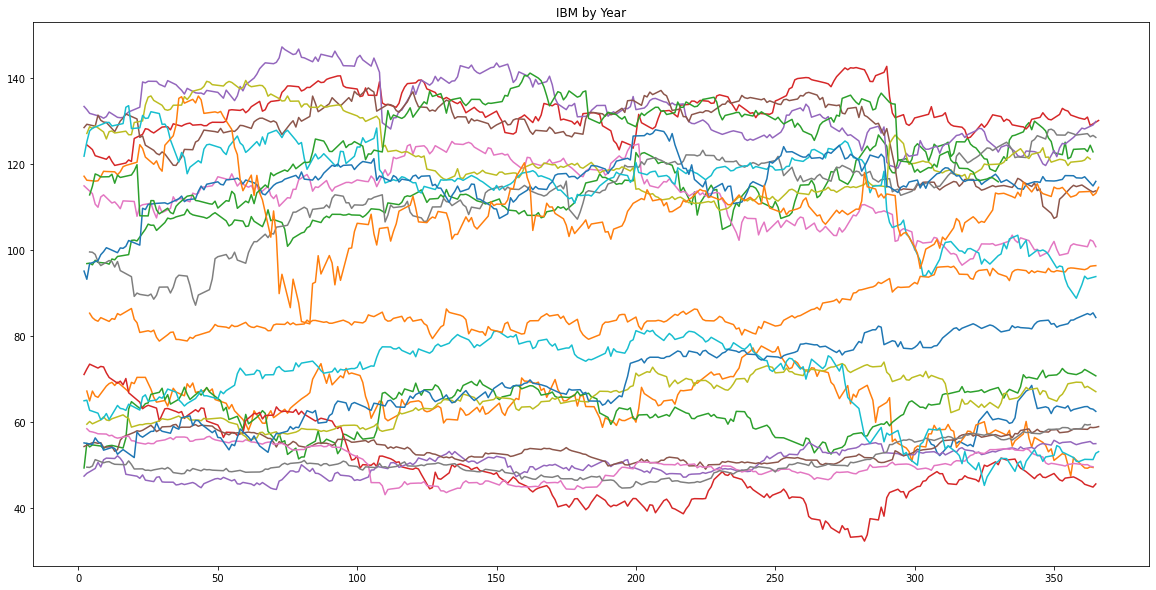

In [7]:
import numpy as np
from matplotlib import pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(20, 10))
for year_rows in tqdm(by_years_with_day):
    np_year_rows = np.array(year_rows)[:,[0,6]].T
    plt.plot(np_year_rows[0].astype(int), np_year_rows[1].astype(float))

plt.title(f'{symbol} by Year')
plt.show()

The chart is neat but could use some improvement. 
1. First, it's unclear what year any one of the lines is, and there are way too many lines to use a legend.
1. Second, the labels seem a bit too small, and I could add a grid to help find our place on the chart. 
1. Finally, the default x axis tick location isn't ideal, and would be better if it was split up logically by quarters, months, and maybe weeks if space allows. 

## 7. Improve The Chart
I add these improvements to the chart below.
1. I use a uniform sequential color map (https://matplotlib.org/stable/tutorials/colors/colormaps.html) to visualize the order of the years, and add annotations to make it possible to find individual year lines. Originally I hoped to add hover annotations (https://stackoverflow.com/questions/7908636/how-to-add-hovering-annotations-in-matplotlib) but it turned out more convoluted than I was hoping (requiring additional configuration and %matplotlib notebook or %matplotlib widget directives to support interactivity). That's out of scope for now and I will work on it another time.
1. Changing the font is straightforward.
1. I expected setting up the axes intervals to be a little tricky but turned out pretty easy...

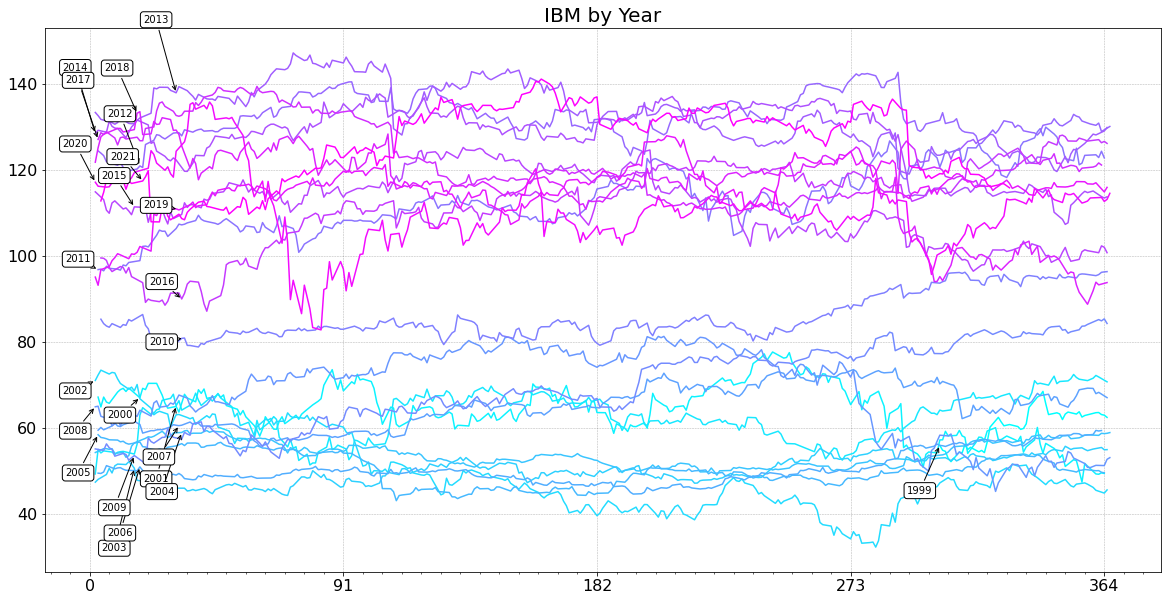

In [8]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
from matplotlib import cm
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

fig, ax = plt.subplots(1, 1, figsize=(20, 10))

plt.title(f'{symbol} by Year', fontsize=20)

# create color map
color_map = cm.get_cmap('cool', len(by_years_with_day))
color_map = color_map(np.linspace(0, 1, len(by_years_with_day)))
    # color_map = np.flip(color_map, axis=0) # <-- can flip the color map like this if want to

# make the font bigger
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# set major ticks to every quarter
ax.xaxis.set_major_locator(MultipleLocator(91))
# set minor ticks to every week
ax.xaxis.set_minor_locator(MultipleLocator(7))

# add quarter vertical lines
plt.grid(True, 'major', 'x', ls='--', lw=.5, c='k', alpha=.3)
plt.grid(True, 'major', 'y', ls='--', lw=.5, c='k', alpha=.3)

# calculate annotation offsets to spread them out so they don't overlap so much:

annot_y_range = 160
annot_y_incr = annot_y_range / len(by_years_with_day)
annot_y_offset = -annot_y_range / 2

year_start_y = [[indx,float(elmt[0][6])] for indx, elmt in enumerate(by_years_with_day)]
#print(year_start_y)
year_start_y.sort(key=lambda x: x[1])
#print(year_start_y)
annot_y_offsets = {elmt[0]:annot_y_offset + indx*annot_y_incr for indx, elmt in enumerate(year_start_y)}
#print(annot_y_offsets)

# plot the lines:

for indx, year_rows in enumerate(by_years_with_day):
    year = pd.to_datetime(year_rows[0][1], format='%Y-%m-%d').year
    np_year_rows = np.array(year_rows)[:,[0,6]].T
    plt.plot(np_year_rows[0].astype(int), np_year_rows[1].astype(float), 
             color=color_map[indx])
    
    # annotate the lines
    ax.annotate(str(year), xy=(int(np_year_rows[0][10*(indx%3)]),float(np_year_rows[1][10*(indx%3)])), 
                    xycoords='data',
                    xytext=(-20,annot_y_offsets[indx]),
                    textcoords="offset points",
                    fontsize=10,
                    va="center",
                    ha="center",
                    bbox=dict(boxstyle="round", fc="w"),
                    arrowprops=dict(arrowstyle="->"))

    
plt.show()

I accomplished most of the goals I set for myself in this exercise with the above chart, and while no patterns are immediately obvious, some things do stand out, like a tendency for some stocks to move significantly every quarter. One clear and obvious pattern presents itself, in a saying, "the market always goes up". While that isn't always true for individual stocks, looking at big companies and overall market this tendency shows with earlier years painted lower on the chart.

## 8. One Last 3D Touch
One last touch-up I can make to this graph is to plot it in 3D so the yearly sequence is even more obvious:

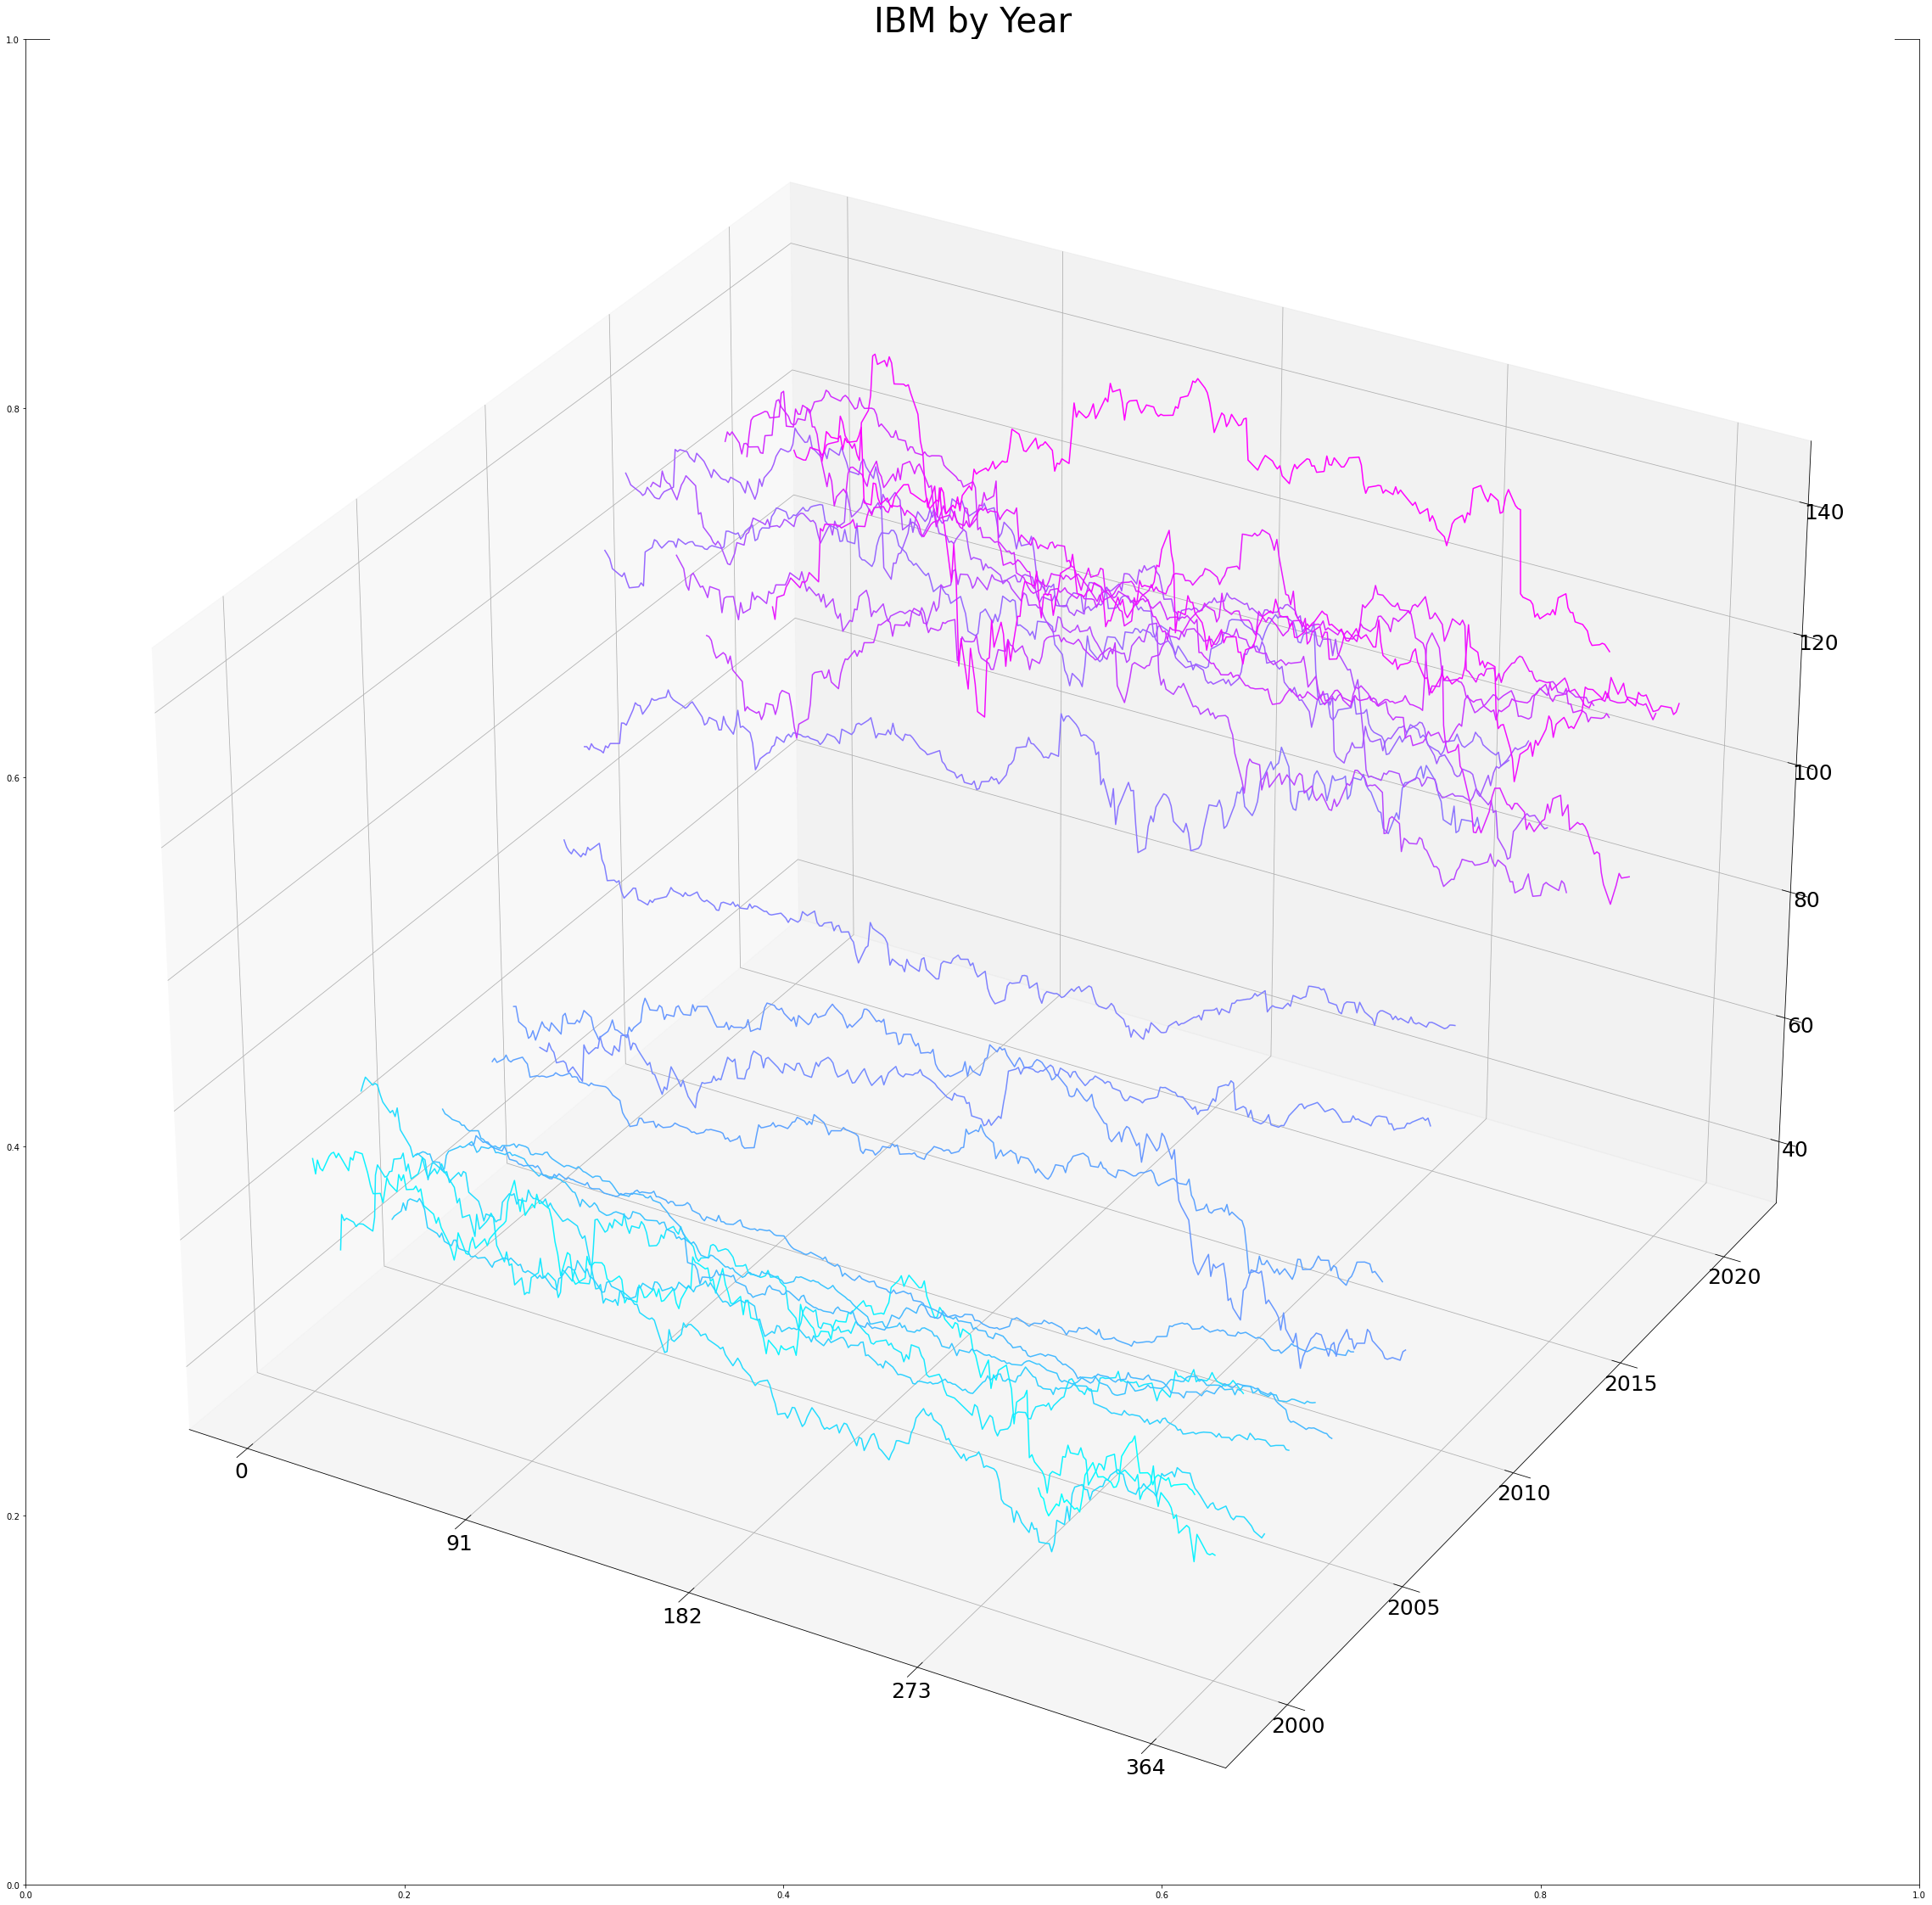

In [9]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
from matplotlib import cm
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from mpl_toolkits import mplot3d

fig, ax = plt.subplots(1, 1, figsize=(40, 40))

plt.title(f'{symbol} by Year', fontsize=40)

# the big difference, 3d axes:
ax = plt.axes(projection='3d')

# create color map
color_map = cm.get_cmap('cool', len(by_years_with_day))
color_map = color_map(np.linspace(0, 1, len(by_years_with_day)))
    # color_map = np.flip(color_map, axis=0) # <-- can flip the color map like this if want to

# make the font bigger
ax.xaxis.set_tick_params(labelsize=25)
ax.yaxis.set_tick_params(labelsize=25)
ax.zaxis.set_tick_params(labelsize=25)

# set major ticks to every quarter
ax.xaxis.set_major_locator(MultipleLocator(91))
ax.yaxis.set_major_locator(MultipleLocator(5))


for indx, year_rows in enumerate(by_years_with_day):
    year = pd.to_datetime(year_rows[0][1], format='%Y-%m-%d').year
    np_year_rows = np.array(year_rows)[:,[0,6]].T
    z = np.linspace(year, year, len(np_year_rows[0]))
    ax.plot3D(np_year_rows[0].astype(int), z, np_year_rows[1].astype(float), color=color_map[indx])
    
    
plt.show()

I've made some small adjustments to the plot for the sake of aesthetics and because of differences between 2d and 3d matplotlib api. I omitted minor tick marks because I couldn't find a way to draw them without also drawing corresponding grid lines. I also didn't add annotations, because I am tired and want to go to bed.

# *Reference
For stuff I may or may not need, and can be ignored

In [10]:
%lsmagic

Available line magics:
%alias  %alias_magic  %autoawait  %autocall  %automagic  %autosave  %bookmark  %cat  %cd  %clear  %colors  %conda  %config  %connect_info  %cp  %debug  %dhist  %dirs  %doctest_mode  %ed  %edit  %env  %gui  %hist  %history  %killbgscripts  %ldir  %less  %lf  %lk  %ll  %load  %load_ext  %loadpy  %logoff  %logon  %logstart  %logstate  %logstop  %ls  %lsmagic  %lx  %macro  %magic  %man  %matplotlib  %mkdir  %more  %mv  %notebook  %page  %pastebin  %pdb  %pdef  %pdoc  %pfile  %pinfo  %pinfo2  %pip  %popd  %pprint  %precision  %prun  %psearch  %psource  %pushd  %pwd  %pycat  %pylab  %qtconsole  %quickref  %recall  %rehashx  %reload_ext  %rep  %rerun  %reset  %reset_selective  %rm  %rmdir  %run  %save  %sc  %set_env  %store  %sx  %system  %tb  %time  %timeit  %unalias  %unload_ext  %who  %who_ls  %whos  %xdel  %xmode

Available cell magics:
%%!  %%HTML  %%SVG  %%bash  %%capture  %%debug  %%file  %%html  %%javascript  %%js  %%latex  %%markdown  %%perl  %%prun  %%pypy  %%